<a href="https://colab.research.google.com/github/HEM2058/sentinelhub_remote_sensing/blob/main/NDVI_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
pip install sentinelhub rasterio geopandas

In [37]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, SHConfig, BBox
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import shape, mapping
from rasterio.features import shapes
import folium
import geopandas as gpd

# Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = 'd756c5fd-609b-4334-8176-894d83e9b8bd'
config.sh_client_secret = 'SK3A5EZxKNWsL0oQOxexcrZT8Lv8lwdo'

# Load GeoJSON polygon for clipping
geojson_polygon = {
    "type": "Polygon",
    "coordinates": [
 [
            [
              86.28225068995674,
              26.62481291231584,
              0
            ],
            [
              86.28224163578312,
              26.62478522397374,
              0
            ],
            [
              86.28220805420203,
              26.6246945573185,
              0
            ],
            [
              86.28231752537012,
              26.62465259645139,
              0
            ],
            [
              86.28240995160007,
              26.62461651165549,
              0
            ],
            [
              86.282517929061,
              26.62456186664692,
              0
            ],
            [
              86.28260960343783,
              26.62452507632441,
              0
            ],
            [
              86.28270582286608,
              26.624682951183,
              0
            ],
            [
              86.28267054008988,
              26.62472665332809,
              0
            ],
            [
              86.2825986525647,
              26.62474385199216,
              0
            ],
            [
              86.28246134995317,
              26.6247846264501,
              0
            ],
            [
              86.28234322596529,
              26.62482739347243,
              0
            ],
            [
              86.28227844974634,
              26.62485213212227,
              0
            ],
            [
              86.28225068995674,
              26.62481291231584,
              0
            ]
          ]
    ]
}


polygon = shape(geojson_polygon)

# Define bounding box based on the polygon
bbox = rasterio.features.bounds(polygon)

# Create BBox object
bbox = BBox(bbox=(bbox[0], bbox[1], bbox[2], bbox[3]), crs=CRS.WGS84)


# Evalscript to calculate NDVI
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B05"], // Red and NIR bands
    output: { bands: 1, sampleType: "FLOAT32" } // NDVI will be output as a single band
  };
}

function evaluatePixel(sample) {
  // Calculate NDVI
  var ndvi = (sample.B05 - sample.B04) / (sample.B05 + sample.B04);
  // Return NDVI value
  return [ndvi];
}
"""

# Create SentinelHub request
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LANDSAT_OT_L2,
            time_interval=('2023-11-24', '2024-04-24'),
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),  # Use TIFF format
    ],
    bbox=bbox,  # Use the calculated bounding box
    size=[512, 354.253],
    config=config,
)

# Fetch data from the request
response = request.get_data()
response_data = response[0]
print(response_data)

# Define geospatial information
transform = rasterio.transform.from_bounds(*bbox, response_data.shape[1], response_data.shape[0])

# Reclassify the raster data based on NDVI values
def reclassify_ndvi(ndvi_array):
    classified_array = np.zeros_like(ndvi_array, dtype=np.uint8)
    classified_array[(ndvi_array <= 0)] = 1  # Water or Non-vegetated
    classified_array[(ndvi_array > 0) & (ndvi_array <= 0.1)] = 1  # Barren Areas
    classified_array[(ndvi_array > 0.1) & (ndvi_array <= 0.2)] = 2  # Sparse Vegetation
    classified_array[(ndvi_array > 0.2) & (ndvi_array <= 0.4)] = 3  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.4) & (ndvi_array <= 0.5)] = 4  # Very Dense Vegetation
    classified_array[(ndvi_array > 0.5) & (ndvi_array <= 0.6)] = 5  # Sparse Vegetation
    classified_array[(ndvi_array > 0.6) & (ndvi_array <= 0.65)] = 6  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.65) & (ndvi_array <= 0.7)] = 7
    classified_array[(ndvi_array > 0.7) & (ndvi_array <= 1)] = 8
    return classified_array

classified_image = reclassify_ndvi(response_data)

# Convert the classified raster to vector GeoJSON
shapes_gen = shapes(classified_image, mask=None, transform=transform)
geometries = list(shapes_gen)

features = []
for geom, value in geometries:
    if value != 0:  # Skip no-data values
        features.append({
            "type": "Feature",
            "geometry": geom,
            "properties": {
                "class_no": value  # Assign value to a property named "label" (or any desired name)
            }  # Convert value to label
        })

geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

# Convert the GeoJSON polygon to a GeoDataFrame
geojson_polygon_df = gpd.GeoDataFrame(geometry=[polygon])

# Convert the GeoJSON data to a GeoDataFrame
geojson_data_df = gpd.GeoDataFrame.from_features(geojson_data)

# Perform intersection using clip
intersection_df = gpd.clip(geojson_data_df, geojson_polygon_df)

# Print the output GeoDataFrame
# print(intersection_df)




# Define color palette for each class
class_colors = {
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'red',
    6: 'purple',
    7: 'pink',
    8: 'cyan'
}

# Create a Folium map centered around the polygon
m = folium.Map(location=[ 29.52593126643867,80.43649590739976], zoom_start=15)

# Create a dictionary to store color for each class
class_color_dict = {}

# Iterate through the features and assign color based on class number
for feature in intersection_df.iterrows():
    class_no = feature[1]['class_no']
    if class_no not in class_color_dict:
        class_color_dict[class_no] = class_colors[len(class_color_dict) + 1]  # Assign a new color
    color = class_color_dict[class_no]
    folium.GeoJson(feature[1]['geometry'], style_function=lambda x, color=color: {'color': color}).add_to(m)

# Display the map
m



[[0.2931968  0.2931968  0.2931968  ... 0.44176587 0.44176587 0.44176587]
 [0.2931968  0.2931968  0.2931968  ... 0.44176587 0.44176587 0.44176587]
 [0.2931968  0.2931968  0.2931968  ... 0.44176587 0.44176587 0.44176587]
 ...
 [0.24776477 0.24776477 0.24776477 ... 0.30233914 0.30233914 0.30233914]
 [0.24776477 0.24776477 0.24776477 ... 0.30233914 0.30233914 0.30233914]
 [0.24776477 0.24776477 0.24776477 ... 0.30233914 0.30233914 0.30233914]]


In [83]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, SHConfig, BBox, SentinelHubCatalog
from shapely.geometry import shape

# Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = 'd756c5fd-609b-4334-8176-894d83e9b8bd'
config.sh_client_secret = 'SK3A5EZxKNWsL0oQOxexcrZT8Lv8lwdo'
config.sh_base_url = "https://services-uswest2.sentinel-hub.com"

# Initialize Sentinel Hub catalog
catalog = SentinelHubCatalog(config=config)

# Load GeoJSON polygon for clipping
geojson_polygon = {
    "type": "Polygon",
    "coordinates": [
        [
            [86.28225068995674, 26.62481291231584, 0],
            [86.28224163578312, 26.62478522397374, 0],
            [86.28220805420203, 26.6246945573185, 0],
            [86.28231752537012, 26.62465259645139, 0],
            [86.28240995160007, 26.62461651165549, 0],
            [86.282517929061, 26.62456186664692, 0],
            [86.28260960343783, 26.62452507632441, 0],
            [86.28270582286608, 26.624682951183, 0],
            [86.28267054008988, 26.62472665332809, 0],
            [86.2825986525647, 26.62474385199216, 0],
            [86.28246134995317, 26.6247846264501, 0],
            [86.28234322596529, 26.62482739347243, 0],
            [86.28227844974634, 26.62485213212227, 0],
            [86.28225068995674, 26.62481291231584, 0]
        ]
    ]
}

# Convert GeoJSON polygon to Shapely geometry
polygon = shape(geojson_polygon)

# Calculate bounding box from polygon
bbox = polygon.bounds

# Create BBox object
bbox = BBox(bbox=(bbox[0], bbox[1], bbox[2], bbox[3]), crs=CRS.WGS84)

# Perform catalog search for Landsat imagery using filter
time_interval = ('2023-11-24', '2024-05-24')
search_iterator = catalog.search(
    collection=DataCollection.LANDSAT_OT_L2,
    bbox=bbox,
    time=time_interval,
    filter = "eo:cloud_cover < 20",
    fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []}

)

# Convert search results iterator to list

results = list(search_iterator)
print(results)




[{'id': 'LC08_L2SP_140042_20240501_20240511_02_T1', 'properties': {'datetime': '2024-05-01T04:41:54.477Z', 'eo:cloud_cover': 0.09}}, {'id': 'LC08_L2SP_140041_20240501_20240511_02_T1', 'properties': {'datetime': '2024-05-01T04:41:30.578Z', 'eo:cloud_cover': 14.07}}, {'id': 'LC09_L2SP_140042_20240423_20240424_02_T1', 'properties': {'datetime': '2024-04-23T04:42:12.553Z', 'eo:cloud_cover': 1.82}}, {'id': 'LC08_L2SP_140042_20240415_20240423_02_T1', 'properties': {'datetime': '2024-04-15T04:42:06.066Z', 'eo:cloud_cover': 0.94}}, {'id': 'LC08_L2SP_140041_20240415_20240423_02_T1', 'properties': {'datetime': '2024-04-15T04:41:42.175Z', 'eo:cloud_cover': 16.2}}, {'id': 'LC09_L2SP_140041_20240407_20240408_02_T1', 'properties': {'datetime': '2024-04-07T04:42:09.227Z', 'eo:cloud_cover': 15.0}}, {'id': 'LC09_L2SP_140042_20240322_20240323_02_T1', 'properties': {'datetime': '2024-03-22T04:42:41.918Z', 'eo:cloud_cover': 14.48}}, {'id': 'LC08_L2SP_140042_20240314_20240401_02_T1', 'properties': {'dateti

['2023-12-17', '2023-12-25', '2024-02-03', '2024-02-11', '2024-02-19', '2024-03-06', '2024-03-14', '2024-03-22', '2024-04-07', '2024-04-15', '2024-04-23', '2024-05-01']


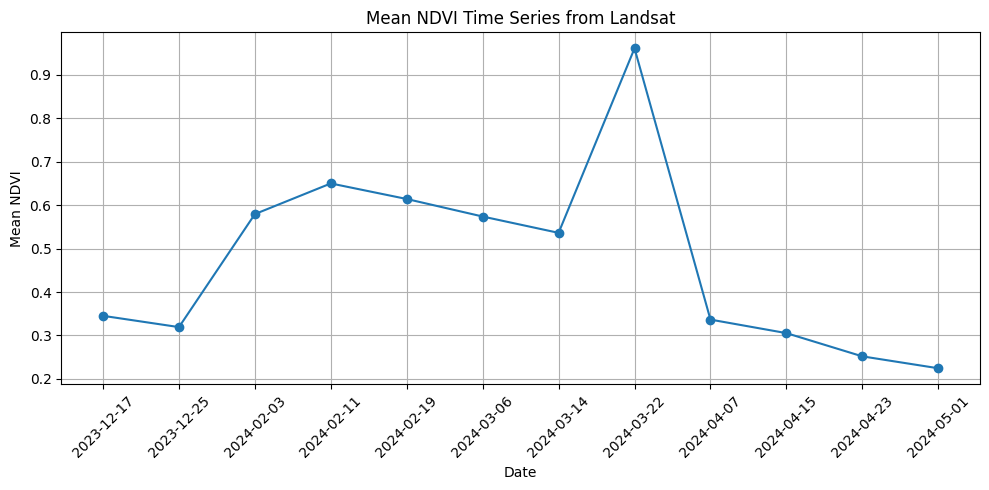

In [85]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, SHConfig, BBox, SentinelHubCatalog
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import shape
from datetime import datetime
import rasterio

# Sentinel Hub credentials and configuration
config = SHConfig()
config.sh_client_id = 'd756c5fd-609b-4334-8176-894d83e9b8bd'
config.sh_client_secret = 'SK3A5EZxKNWsL0oQOxexcrZT8Lv8lwdo'
config.sh_base_url = "https://services-uswest2.sentinel-hub.com"

# Load GeoJSON polygon for clipping
geojson_polygon = {
    "type": "Polygon",
    "coordinates": [
   [
          [86.28216031642039, 26.6246047201047],
          [86.28205495190723, 26.62439384584329],
          [86.28231495322967, 26.62430982408871],
          [86.28240126351798, 26.62428273467491],
          [86.28253561105903, 26.62441923502021],
          [86.28216031642039, 26.6246047201047]
        ]
    ]
}

# Convert GeoJSON polygon to Shapely geometry
polygon = shape(geojson_polygon)

# Calculate bounding box from polygon
bbox = rasterio.features.bounds(polygon)
bbox = BBox(bbox=(bbox[0], bbox[1], bbox[2], bbox[3]), crs=CRS.WGS84)

# Initialize Sentinel Hub catalog
catalog = SentinelHubCatalog(config=config)

# Define time interval
time_interval = ('2023-11-24', '2024-05-24')

# Perform catalog search for Landsat imagery
search_iterator = catalog.search(
    collection=DataCollection.LANDSAT_OT_L2,
    bbox=bbox,
    time=time_interval,
    filter = "eo:cloud_cover < 20",
    fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []}
)


# Extract dates from filtered results
dates = []
for result in search_iterator:
    sensing_time = result['properties'].get('datetime', None)
    if sensing_time:
        # Extract date in YYYY-MM-DD format
        date = sensing_time[:10]  # Extracts 'YYYY-MM-DD'
        dates.append(date)

# Remove duplicate dates
dates = list(set(dates))
dates.sort()
print(dates)


# Define evalscript for NDVI calculation
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B05"], // Red and NIR bands for Landsat
    output: { bands: 1, sampleType: "FLOAT32" }
  };
}

function evaluatePixel(sample) {
  // Calculate NDVI
  var ndvi = (sample.B05 - sample.B04) / (sample.B05 + sample.B04);

  // Ensure NDVI is non-negative
  if (ndvi < 0) {
    return [0];  // Set NDVI to 0 if negative
  }

  return [ndvi];
}
"""


# List to store mean NDVI values
mean_ndvi_values = []

# Loop over each date and calculate NDVI
for date in dates:
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.LANDSAT_OT_L2,
                time_interval=(date, date),
                mosaicking_order="leastCC"  # Mosaicking order for Landsat
            ),
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF),
        ],
        bbox=bbox,
        size=[512, 512],
        config=config
    )

    # Fetch data from request
    response = request.get_data()
    response_data = response[0]

    # Remove zero values (clipped pixels)
    response_data = response_data[response_data != 0]

    # Calculate mean NDVI
    mean_ndvi = np.mean(response_data)
    mean_ndvi_values.append(mean_ndvi)

# Plot mean NDVI values against dates
plt.figure(figsize=(10, 5))
plt.plot(dates, mean_ndvi_values, marker='o')
plt.xlabel('Date')
plt.ylabel('Mean NDVI')
plt.title('Mean NDVI Time Series from Landsat')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


['2023-12-18', '2023-12-23', '2023-12-28', '2024-01-02', '2024-01-07', '2024-01-12', '2024-01-17', '2024-01-22', '2024-01-27', '2024-02-01', '2024-02-06', '2024-02-11', '2024-02-16', '2024-02-21', '2024-02-26', '2024-03-02', '2024-03-07', '2024-03-12', '2024-03-17', '2024-03-22', '2024-03-27', '2024-04-01', '2024-04-06', '2024-04-11']


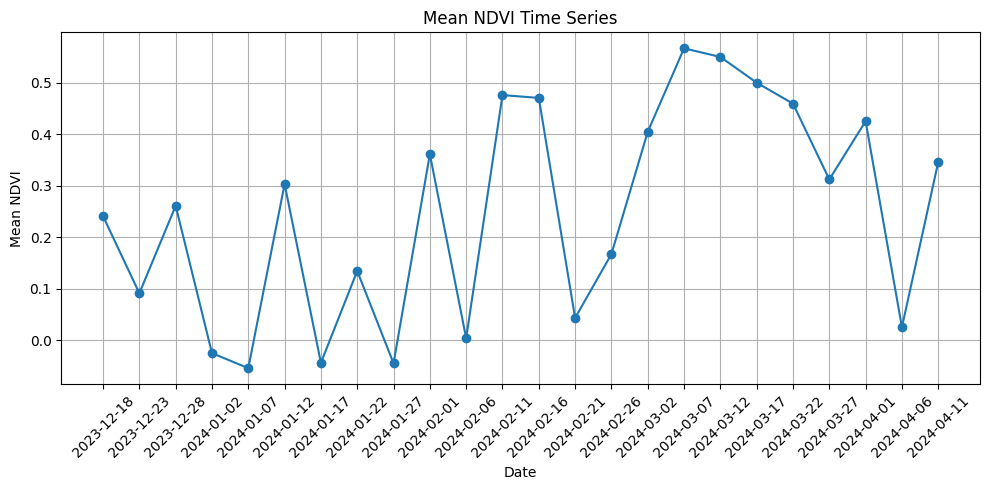

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, SHConfig, BBox, SentinelHubCatalog
import rasterio
from datetime import datetime

# Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = 'd756c5fd-609b-4334-8176-894d83e9b8bd'
config.sh_client_secret = 'SK3A5EZxKNWsL0oQOxexcrZT8Lv8lwdo'

# Load GeoJSON polygon for clipping
geojson_polygon = {
    "type": "Polygon",
    "coordinates": [
[
            [
              86.28225068995674,
              26.62481291231584,
              0
            ],
            [
              86.28224163578312,
              26.62478522397374,
              0
            ],
            [
              86.28220805420203,
              26.6246945573185,
              0
            ],
            [
              86.28231752537012,
              26.62465259645139,
              0
            ],
            [
              86.28240995160007,
              26.62461651165549,
              0
            ],
            [
              86.282517929061,
              26.62456186664692,
              0
            ],
            [
              86.28260960343783,
              26.62452507632441,
              0
            ],
            [
              86.28270582286608,
              26.624682951183,
              0
            ],
            [
              86.28267054008988,
              26.62472665332809,
              0
            ],
            [
              86.2825986525647,
              26.62474385199216,
              0
            ],
            [
              86.28246134995317,
              26.6247846264501,
              0
            ],
            [
              86.28234322596529,
              26.62482739347243,
              0
            ],
            [
              86.28227844974634,
              26.62485213212227,
              0
            ],
            [
              86.28225068995674,
              26.62481291231584,
              0
            ]
          ]
    ]
}

polygon = shape(geojson_polygon)

# Define bounding box based on the polygon
bbox = rasterio.features.bounds(polygon)
bbox = BBox(bbox=(bbox[0], bbox[1], bbox[2], bbox[3]), crs=CRS.WGS84)

# Evalscript to calculate NDVI
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08"], // Red and NIR bands
    output: { bands: 1, sampleType: "FLOAT32" } // NDVI will be output as a single band
  };
}

function evaluatePixel(sample) {
  // Calculate NDVI
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  // Return NDVI value
  return [ndvi];
}
"""

# Define the date range
start_date = '2023-12-16'
end_date = '2024-04-13'

# Create a SentinelHubCatalog instance
catalog = SentinelHubCatalog(config=config)

# Search for available Sentinel-2 data
search_results = catalog.search(
    collection=DataCollection.SENTINEL2_L2A,
    bbox=bbox,
    time=(start_date, end_date),
)

# Extract unique dates from search results
dates = set()
for result in search_results:
    sensing_time = result['properties'].get('datetime', None)
    if sensing_time is not None:
        sensing_date = datetime.fromisoformat(sensing_time[:-1]).date().isoformat()
        dates.add(sensing_date)

# Convert the set to a sorted list
available_dates = sorted(dates)
print(available_dates)

# List to store mean NDVI values
mean_ndvi_values = []

for date in available_dates:
    # Create SentinelHub request
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(date, date),
            ),
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF),  # Use TIFF format
        ],
        bbox=bbox,  # Use the calculated bounding box
        size=[512, 354],
        config=config,
    )

    # Fetch data from the request
    response = request.get_data()
    response_data = response[0]

    # Remove zero values (clipped pixels)
    response_data = response_data[response_data != 0]

    # Calculate mean NDVI
    mean_ndvi = np.mean(response_data)
    mean_ndvi_values.append(mean_ndvi)

# Plot the mean NDVI values against the dates
plt.figure(figsize=(10, 5))
plt.plot(available_dates, mean_ndvi_values, marker='o')
plt.xlabel('Date')
plt.ylabel('Mean NDVI')
plt.title('Mean NDVI Time Series')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


['2023-12-18', '2023-12-23', '2023-12-28', '2024-01-02', '2024-01-07', '2024-01-12', '2024-01-17', '2024-01-22', '2024-01-27', '2024-02-01', '2024-02-06', '2024-02-11', '2024-02-16', '2024-02-21', '2024-02-26', '2024-03-02', '2024-03-07', '2024-03-12', '2024-03-17', '2024-03-22', '2024-03-27', '2024-04-01', '2024-04-06', '2024-04-11']


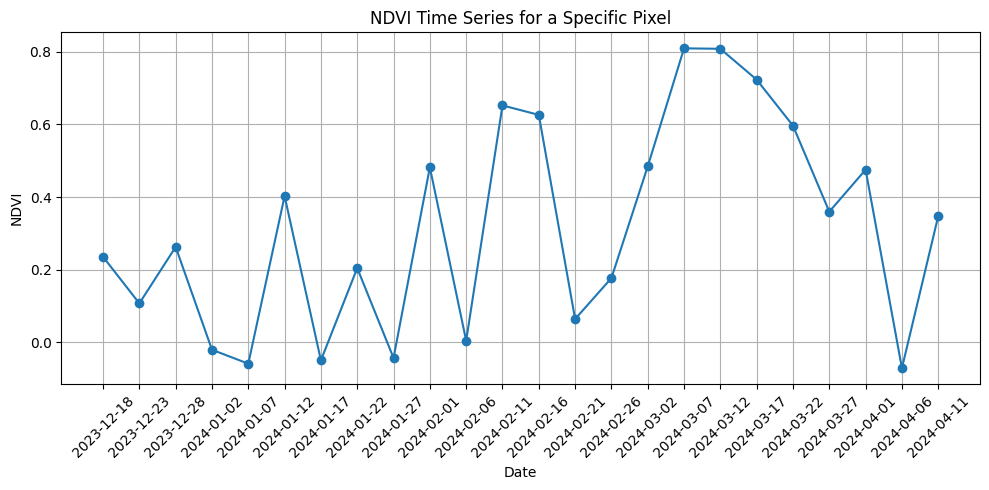

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, SHConfig, BBox, SentinelHubCatalog
from shapely.geometry import shape
import rasterio
from datetime import datetime

# Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = 'd756c5fd-609b-4334-8176-894d83e9b8bd'
config.sh_client_secret = 'SK3A5EZxKNWsL0oQOxexcrZT8Lv8lwdo'

# Load GeoJSON polygon for clipping
geojson_polygon = {
    "type": "Polygon",
    "coordinates": [
        [
            [
              86.28225068995674,
              26.62481291231584,
              0
            ],
            [
              86.28224163578312,
              26.62478522397374,
              0
            ],
            [
              86.28220805420203,
              26.6246945573185,
              0
            ],
            [
              86.28231752537012,
              26.62465259645139,
              0
            ],
            [
              86.28240995160007,
              26.62461651165549,
              0
            ],
            [
              86.282517929061,
              26.62456186664692,
              0
            ],
            [
              86.28260960343783,
              26.62452507632441,
              0
            ],
            [
              86.28270582286608,
              26.624682951183,
              0
            ],
            [
              86.28267054008988,
              26.62472665332809,
              0
            ],
            [
              86.2825986525647,
              26.62474385199216,
              0
            ],
            [
              86.28246134995317,
              26.6247846264501,
              0
            ],
            [
              86.28234322596529,
              26.62482739347243,
              0
            ],
            [
              86.28227844974634,
              26.62485213212227,
              0
            ],
            [
              86.28225068995674,
              26.62481291231584,
              0
            ]
        ]
    ]
}

polygon = shape(geojson_polygon)

# Define bounding box based on the polygon
bbox = rasterio.features.bounds(polygon)
bbox = BBox(bbox=(bbox[0], bbox[1], bbox[2], bbox[3]), crs=CRS.WGS84)

# Evalscript to calculate NDVI
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08"], // Red and NIR bands
    output: { bands: 1, sampleType: "FLOAT32" } // NDVI will be output as a single band
  };
}

function evaluatePixel(sample) {
  // Calculate NDVI
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  // Return NDVI value
  return [ndvi];
}
"""


# Define the date range
start_date = '2023-12-16'
end_date = '2024-04-13'

# Create a SentinelHubCatalog instance
catalog = SentinelHubCatalog(config=config)

# Search for available Sentinel-2 data
search_results = catalog.search(
    collection=DataCollection.SENTINEL2_L2A,
    bbox=bbox,
    time=(start_date, end_date),
)
print(search_results)

# Extract unique dates from search results
dates = set()
for result in search_results:
    sensing_time = result['properties'].get('datetime', None)
    if sensing_time is not None:
        sensing_date = datetime.fromisoformat(sensing_time[:-1]).date().isoformat()
        dates.add(sensing_date)

# Convert the set to a sorted list
available_dates = sorted(dates)
print(available_dates)

# Define the specific pixel coordinates (within the bounding box)
pixel_x = 0  # Example pixel x-coordinate
pixel_y = 0  # Example pixel y-coordinate

# List to store NDVI values for the specific pixel
pixel_ndvi_values = []

for date in available_dates:
    # Create SentinelHub request
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(date, date),
            ),
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF),  # Use TIFF format
        ],
        bbox=bbox,  # Use the calculated bounding box
        size=[512, 354],
        config=config,
    )

    # Fetch data from the request
    response = request.get_data()
    response_data = response[0]

    # Extract NDVI value for the specific pixel
    pixel_ndvi = response_data[pixel_y, pixel_x]
    pixel_ndvi_values.append(pixel_ndvi)

# Plot the NDVI values for the specific pixel against the dates
plt.figure(figsize=(10, 5))
plt.plot(available_dates, pixel_ndvi_values, marker='o')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series for a Specific Pixel')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, SHConfig, BBox, SentinelHubCatalog
from shapely.geometry import shape
import rasterio
from datetime import datetime

# Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = 'd756c5fd-609b-4334-8176-894d83e9b8bd'
config.sh_client_secret = 'SK3A5EZxKNWsL0oQOxexcrZT8Lv8lwdo'

# Load GeoJSON polygon for clipping
geojson_polygon = {
    "type": "Polygon",
    "coordinates": [
        [
            [
              86.28225068995674,
              26.62481291231584,
              0
            ],
            [
              86.28224163578312,
              26.62478522397374,
              0
            ],
            [
              86.28220805420203,
              26.6246945573185,
              0
            ],
            [
              86.28231752537012,
              26.62465259645139,
              0
            ],
            [
              86.28240995160007,
              26.62461651165549,
              0
            ],
            [
              86.282517929061,
              26.62456186664692,
              0
            ],
            [
              86.28260960343783,
              26.62452507632441,
              0
            ],
            [
              86.28270582286608,
              26.624682951183,
              0
            ],
            [
              86.28267054008988,
              26.62472665332809,
              0
            ],
            [
              86.2825986525647,
              26.62474385199216,
              0
            ],
            [
              86.28246134995317,
              26.6247846264501,
              0
            ],
            [
              86.28234322596529,
              26.62482739347243,
              0
            ],
            [
              86.28227844974634,
              26.62485213212227,
              0
            ],
            [
              86.28225068995674,
              26.62481291231584,
              0
            ]
        ]
    ]
}

polygon = shape(geojson_polygon)

# Define bounding box based on the polygon
bbox = rasterio.features.bounds(polygon)
bbox = BBox(bbox=(bbox[0], bbox[1], bbox[2], bbox[3]), crs=CRS.WGS84)

# Evalscript to calculate NDVI for LANDSAT
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B05"], // Red and NIR bands for LANDSAT
    output: { bands: 1, sampleType: "FLOAT32" } // NDVI will be output as a single band
  };
}

function evaluatePixel(sample) {
  // Calculate NDVI
  var ndvi = (sample.B05 - sample.B04) / (sample.B05 + sample.B04);
  // Return NDVI value
  return [ndvi];
}
"""

# Define the date range
start_date = '2023-12-16'
end_date = '2024-04-13'

# Create a SentinelHubCatalog instance
catalog = SentinelHubCatalog(config=config)

# Search for available LANDSAT data
search_results = catalog.search(
    collection=DataCollection.LANDSAT_OT_L2,
    bbox=bbox,
    time=(start_date, end_date),
)
print(search_results)
# Extract unique dates from search results
dates = set()
for result in search_results:
    print(result)
    sensing_time = result['properties'].get('datetime', None)
    if sensing_time is not None:
        sensing_date = datetime.fromisoformat(sensing_time[:-1]).date().isoformat()
        dates.add(sensing_date)

# Convert the set to a sorted list
available_dates = sorted(dates)
print(available_dates)

# Define the specific pixel coordinates (within the bounding box)
pixel_x = 0  # Example pixel x-coordinate
pixel_y = 0  # Example pixel y-coordinate

# List to store NDVI values for the specific pixel
pixel_ndvi_values = []

for date in available_dates:
    # Create SentinelHub request
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.LANDSAT_TM_L1,
                time_interval=(date, date),
            ),
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF),  # Use TIFF format
        ],
        bbox=bbox,  # Use the calculated bounding box
        size=[512, 354],
        config=config,
    )

    # Fetch data from the request
    response = request.get_data()
    response_data = response[0]

    # Extract NDVI value for the specific pixel
    pixel_ndvi = response_data[pixel_y, pixel_x]
    pixel_ndvi_values.append(pixel_ndvi)

# Plot the NDVI values for the specific pixel against the dates
plt.figure(figsize=(10, 5))
plt.plot(available_dates, pixel_ndvi_values, marker='o')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series for a Specific Pixel')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


{'stac_version': '1.0.0', 'stac_extensions': ['https://stac-extensions.github.io/eo/v1.0.0/schema.json', 'https://stac-extensions.github.io/projection/v1.0.0/schema.json'], 'id': 'S2A_MSIL2A_20240411T044701_N0510_R076_T45RVK_20240411T092851', 'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC::CRS84'}}, 'coordinates': [[[[85.99066428090033, 27.118833971927074], [85.9993340825254, 26.127612771606028], [87.09762280704153, 26.131053692557387], [87.09846878677303, 27.122426095978682], [85.99066428090033, 27.118833971927074]]]]}, 'bbox': [85.99066428090033, 26.127612771606028, 87.09846878677303, 27.122426095978682], 'properties': {'datetime': '2024-04-11T05:01:19Z', 'platform': 'sentinel-2a', 'instruments': ['msi'], 'constellation': 'sentinel-2', 'gsd': 10, 'eo:cloud_cover': 1.37, 'proj:epsg': 32645, 'proj:bbox': [399960.0, 2890200.0, 509760.0, 3000000.0], 'proj:geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name

KeyboardInterrupt: 

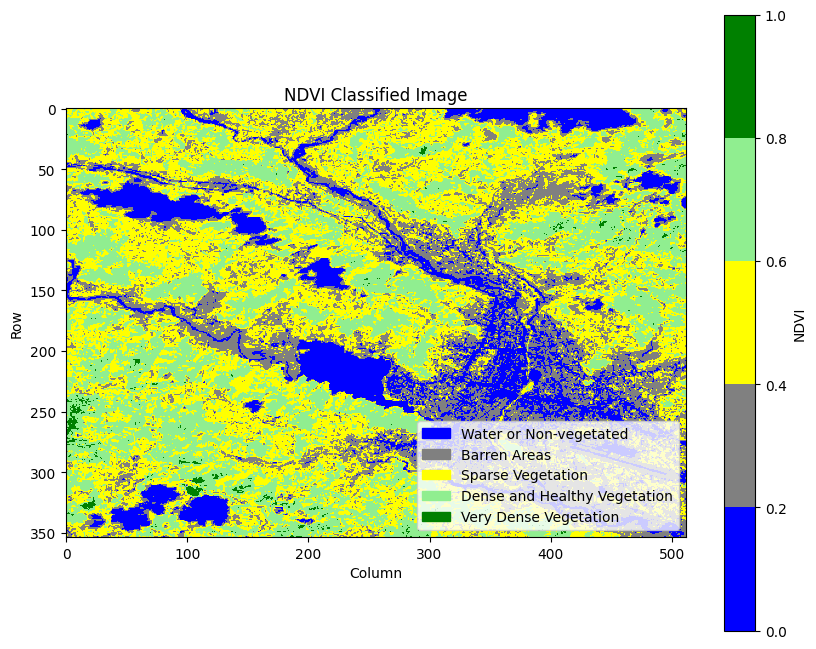

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import numpy as np

# Sample NDVI image data
ndvi_image = response[0]  # Assuming response[0] contains the NDVI data in matrix format

# Define the NDVI classification thresholds and corresponding labels
thresholds = [0, 0.3, 0.6, 0.9, 1]
labels = ['Water or Non-vegetated', 'Barren Areas', 'Sparse Vegetation', 'Dense and Healthy Vegetation', 'Very Dense Vegetation']

# Define colors for each class
colors = ['blue', 'gray', 'yellow', 'lightgreen', 'green']

# Create a colormap based on the defined colors
cmap = ListedColormap(colors)

# Normalize the NDVI values to the range [0, 1]
norm = Normalize(vmin=0, vmax=1)

# Plot the NDVI image with colormap
plt.figure(figsize=(10, 8))
plt.imshow(ndvi_image, cmap=cmap, norm=norm)
plt.colorbar(label='NDVI')
plt.title('NDVI Classified Image')
plt.xlabel('Column')
plt.ylabel('Row')

# Create legend
legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], label=labels[i]) for i in range(len(labels))]
plt.legend(handles=legend_handles, loc='lower right')

plt.show()


In [ ]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import shape, mapping
from rasterio.features import shapes

# Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = 'd756c5fd-609b-4334-8176-894d83e9b8bd'
config.sh_client_secret = 'SK3A5EZxKNWsL0oQOxexcrZT8Lv8lwdo'

# Evalscript to calculate NDVI
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08"], // Red and NIR bands
    output: { bands: 1,
    sampleType: "FLOAT32"  } // NDVI will be output as a single band
  };
}

function evaluatePixel(sample) {
  // Calculate NDVI
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);

  // Return NDVI value
  return [ndvi];
}
"""

# Define bounding box
bbox = BBox(bbox=[83.93433379460498, 28.24635600957282, 83.93568176542095, 28.247151041120986], crs=CRS.WGS84)

# Create SentinelHub request
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2023-11-24', '2024-01-24'),
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),  # Use TIFF format
    ],
    bbox=bbox,
    size=[512, 354.253],
    config=config,
)

# Fetch data from the request
response = request.get_data()
response_data = response[0]

# Load GeoJSON polygon for clipping
geojson_polygon = {
    "type": "Polygon",
    "coordinates": [
[
            [
              83.92967233590457,
              28.2490505439186
            ],
            [
              83.92908937633854,
              28.247411726272375
            ],
            [
              83.93049498923824,
              28.247142547359303
            ],
            [
              83.93248118138047,
              28.2467926137563
            ],
            [
              83.93335205024238,
              28.24792316433596
            ],
            [
              83.93390445300588,
              28.249508139479886
            ],
            [
              83.93274329452277,
              28.250517534508788
            ],
            [
              83.93257523211156,
              28.250275280573618
            ],
            [
              83.9309251647935,
              28.249938815861242
            ],
            [
              83.92967233590457,
              28.2490505439186
            ]
          ]
    ]
}

polygon = shape(geojson_polygon)

# Define geospatial information
transform = rasterio.transform.from_bounds(bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y, response_data.shape[1], response_data.shape[0])

# Reclassify the raster data based on NDVI values
def reclassify_ndvi(ndvi_array):
    print(ndvi_array)
    classified_array = np.zeros_like(ndvi_array, dtype=np.uint8)
    classified_array[(ndvi_array <= 0)] = 1  # Water or Non-vegetated
    classified_array[(ndvi_array > 0) & (ndvi_array <= 0.1)] = 1  # Barren Areas
    classified_array[(ndvi_array > 0.1) & (ndvi_array <= 0.2)] = 2  # Sparse Vegetation
    classified_array[(ndvi_array > 0.2) & (ndvi_array <= 0.4)] = 3  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.4) & (ndvi_array <= 0.5)] = 4  # Very Dense Vegetation
    classified_array[(ndvi_array > 0.5) & (ndvi_array <= 0.6)] =  5  # Sparse Vegetation
    classified_array[(ndvi_array > 0.6) & (ndvi_array <= 0.65)] = 6  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.65) & (ndvi_array <= 0.7)] = 7
    return classified_array

classified_image = reclassify_ndvi(response_data)

# Convert the classified raster to vector GeoJSON
shapes_gen = shapes(classified_image, mask=None, transform=transform)
geometries = list(shapes_gen)

features = []
for geom, value in geometries:
    if value != 0:  # Skip no-data values
        features.append({
            "type": "Feature",
            "geometry": geom,
            "properties": {
                "class_no": value  # Assign value to a property named "label" (or any desired name)
            }  # Convert value to label
        })

geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

print(geojson_data)


[[0.43949842 0.43949842 0.43949842 ... 0.43381858 0.43381858 0.43381858]
 [0.43949842 0.43949842 0.43949842 ... 0.43381858 0.43381858 0.43381858]
 [0.43949842 0.43949842 0.43949842 ... 0.43381858 0.43381858 0.43381858]
 ...
 [0.47352025 0.47352025 0.47352025 ... 0.3305785  0.3305785  0.3305785 ]
 [0.47352025 0.47352025 0.47352025 ... 0.3305785  0.3305785  0.3305785 ]
 [0.47352025 0.47352025 0.47352025 ... 0.3305785  0.3305785  0.3305785 ]]
{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[(83.93453651677848, 28.247151041120986), (83.93453651677848, 28.247126336750846), (83.93454441504498, 28.247126336750846), (83.93454441504498, 28.247124090899014), (83.93463656148748, 28.247124090899014), (83.93463656148748, 28.247144303565495), (83.93463919424298, 28.247144303565495), (83.93463919424298, 28.247151041120986), (83.93453651677848, 28.247151041120986)]]}, 'properties': {'class_no': 6.0}}, {'type': 'Feature', 'geometry': {'type

In [ ]:
import geopandas as gpd
from shapely.geometry import mapping

# Convert the GeoJSON polygon to a GeoDataFrame
geojson_polygon_df = gpd.GeoDataFrame(geometry=[polygon])

# Convert the GeoJSON data to a GeoDataFrame
geojson_data_df = gpd.GeoDataFrame.from_features(geojson_data)

# Perform intersection using clip
intersection_df = gpd.clip(geojson_data_df, geojson_polygon_df)

# Print the output GeoDataFrame
print(intersection_df)


                                             geometry  class_no
3   POLYGON ((83.93472 28.24694, 83.93472 28.24694...       6.0
5   POLYGON ((83.93440 28.24695, 83.93440 28.24695...       5.0
2   POLYGON ((83.93484 28.24703, 83.93484 28.24703...       6.0
1   POLYGON ((83.93453 28.24702, 83.93453 28.24702...       4.0
12  POLYGON ((83.93462 28.24666, 83.93463 28.24666...       3.0
10  POLYGON ((83.93564 28.24647, 83.93564 28.24648...       4.0
7   POLYGON ((83.93564 28.24665, 83.93564 28.24665...       3.0
6   POLYGON ((83.93542 28.24675, 83.93542 28.24674...       5.0
9   MULTIPOLYGON (((83.93515 28.24710, 83.93514 28...       4.0
4   POLYGON ((83.93554 28.24683, 83.93554 28.24683...       3.0


In [ ]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import shape
from rasterio.features import shapes
import geopandas as gpd
import folium


# Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = 'd756c5fd-609b-4334-8176-894d83e9b8bd'
config.sh_client_secret = 'SK3A5EZxKNWsL0oQOxexcrZT8Lv8lwdo'

# Evalscript to calculate NDVI
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08"], // Red and NIR bands
    output: { bands: 1,
    sampleType: "FLOAT32"  } // NDVI will be output as a single band
  };
}

function evaluatePixel(sample) {
  // Calculate NDVI
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);

  // Return NDVI value
  return [ndvi];
}
"""

# Define bounding box
bbox = BBox(bbox=[83.93433379460498, 28.24635600957282, 83.93568176542095, 28.247151041120986], crs=CRS.WGS84)

# Create SentinelHub request
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2023-11-24', '2024-01-24'),
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),  # Use TIFF format
    ],
    bbox=bbox,
    size=[512, 354.253],
    config=config,
)

# Fetch data from the request
response = request.get_data()
response_data = response[0]

geojson_polygon = {
    "type": "Polygon",
    "coordinates": [
        [
            [83.93433379460498, 28.246840164244404],
            [83.9343511504502, 28.24673823715638],
            [83.93443792967332, 28.24672804444276],
            [83.93447842664358, 28.24671785172758],
            [83.93452470889645, 28.246671984497468],
            [83.93462305868212, 28.246646502694574],
            [83.9348024026259, 28.246524189817478],
            [83.93505116973273, 28.246498707979256],
            [83.93521315761637, 28.246478322504615],
            [83.9352825809944, 28.246463033395955],
            [83.935513992256, 28.24635600957282],
            [83.93560655676174, 28.246412069683643],
            [83.93568176542095, 28.24655476801567],
            [83.93561812732423, 28.2467127552312],
            [83.93562969788684, 28.246784104219913],
            [83.93555448922757, 28.24693189840154],
            [83.93547349528575, 28.246987958209644],
            [83.93537514549877, 28.24700834358744],
            [83.93526522515054, 28.247079692378378],
            [83.93514373423704, 28.24710007773801],
            [83.93498174635471, 28.247151041120986],
            [83.93470405284023, 28.247140848446207],
            [83.93440900348185, 28.24704911433072],
            [83.93433379460498, 28.246840164244404]
        ]
    ]
}


polygon = shape(geojson_polygon)

# Define geospatial information
transform = rasterio.transform.from_bounds(bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y, response_data.shape[1], response_data.shape[0])

# Reclassify the raster data based on NDVI values
def reclassify_ndvi(ndvi_array):
    classified_array = np.zeros_like(ndvi_array, dtype=np.uint8)
    classified_array[(ndvi_array <= 0)] = 1  # Water or Non-vegetated
    classified_array[(ndvi_array > 0) & (ndvi_array <= 0.1)] = 1  # Barren Areas
    classified_array[(ndvi_array > 0.1) & (ndvi_array <= 0.2)] = 2  # Sparse Vegetation
    classified_array[(ndvi_array > 0.2) & (ndvi_array <= 0.4)] = 3  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.4) & (ndvi_array <= 0.5)] = 4  # Very Dense Vegetation
    classified_array[(ndvi_array > 0.5) & (ndvi_array <= 0.6)] =  5  # Sparse Vegetation
    classified_array[(ndvi_array > 0.6) & (ndvi_array <= 0.65)] = 6  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.65) & (ndvi_array <= 0.7)] = 7
    return classified_array

classified_image = reclassify_ndvi(response_data)

# Convert the classified raster to vector GeoJSON
shapes_gen = shapes(classified_image, mask=None, transform=transform)
geometries = list(shapes_gen)

features = []
for geom, value in geometries:
    if value != 0:  # Skip no-data values
        features.append({
            "type": "Feature",
            "geometry": geom,
            "properties": {
                "class_no": value  # Assign value to a property named "label" (or any desired name)
            }  # Convert value to label
        })

geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

print(geojson_data)

# Display the map
m



{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[(83.93453651677848, 28.247151041120986), (83.93453651677848, 28.247126336750846), (83.93454441504498, 28.247126336750846), (83.93454441504498, 28.247124090899014), (83.93463656148748, 28.247124090899014), (83.93463656148748, 28.247144303565495), (83.93463919424298, 28.247144303565495), (83.93463919424298, 28.247151041120986), (83.93453651677848, 28.247151041120986)]]}, 'properties': {'class_no': 6.0}}, {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[(83.93433379460498, 28.247151041120986), (83.93433379460498, 28.246948914456198), (83.93440487900348, 28.246948914456198), (83.93440487900348, 28.246946668604366), (83.93451018922347, 28.246946668604366), (83.93451018922347, 28.246944422752538), (83.93453125126747, 28.246944422752538), (83.93453125126747, 28.24701853586296), (83.93453388402298, 28.24701853586296), (83.93453388402298, 28.24711286163986), (83.93

In [ ]:

from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import shape, mapping
from rasterio.features import shapes

# Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = 'd756c5fd-609b-4334-8176-894d83e9b8bd'
config.sh_client_secret = 'SK3A5EZxKNWsL0oQOxexcrZT8Lv8lwdo'

# Evalscript to calculate NDVI
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08"], // Red and NIR bands
    output: { bands: 1,
    sampleType: "FLOAT32"  } // NDVI will be output as a single band
  };
}

function evaluatePixel(sample) {
  // Calculate NDVI
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);

  // Return NDVI value
  return [ndvi];
}
"""
# Define bounding box
bbox = BBox(bbox=[83.93433379460498, 28.24635600957282, 83.93568176542095, 28.247151041120986], crs=CRS.WGS84)

# Create SentinelHub request
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2023-11-24', '2024-01-24'),
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),  # Use TIFF format
    ],
    bbox=bbox,
    size=[512, 354.253],
    config=config,
)

# Fetch data from the request
response = request.get_data()
response_data = response[0]

# Load GeoJSON polygon for clipping
geojson_polygon = {
    "type": "Polygon",
    "coordinates": [
[
            [
              83.92967233590457,
              28.2490505439186
            ],
            [
              83.92908937633854,
              28.247411726272375
            ],
            [
              83.93049498923824,
              28.247142547359303
            ],
            [
              83.93248118138047,
              28.2467926137563
            ],
            [
              83.93335205024238,
              28.24792316433596
            ],
            [
              83.93390445300588,
              28.249508139479886
            ],
            [
              83.93274329452277,
              28.250517534508788
            ],
            [
              83.93257523211156,
              28.250275280573618
            ],
            [
              83.9309251647935,
              28.249938815861242
            ],
            [
              83.92967233590457,
              28.2490505439186
            ]
          ]
    ]
}

polygon = shape(geojson_polygon)

# Define geospatial information
transform = rasterio.transform.from_bounds(bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y, response_data.shape[1], response_data.shape[0])

# Reclassify the raster data based on NDVI values
def reclassify_ndvi(ndvi_array):
    print(ndvi_array)
    classified_array = np.zeros_like(ndvi_array, dtype=np.uint8)
    classified_array[(ndvi_array <= 0)] = 1  # Water or Non-vegetated
    classified_array[(ndvi_array > 0) & (ndvi_array <= 0.1)] = 1  # Barren Areas
    classified_array[(ndvi_array > 0.1) & (ndvi_array <= 0.2)] = 2  # Sparse Vegetation
    classified_array[(ndvi_array > 0.2) & (ndvi_array <= 0.4)] = 3  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.4) & (ndvi_array <= 0.5)] = 4  # Very Dense Vegetation
    classified_array[(ndvi_array > 0.5) & (ndvi_array <= 0.6)] =  5  # Sparse Vegetation
    classified_array[(ndvi_array > 0.6) & (ndvi_array <= 0.65)] = 6  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.65) & (ndvi_array <= 0.7)] = 7
    return classified_array

classified_image = reclassify_ndvi(response_data)

# Convert the classified raster to vector GeoJSON
shapes_gen = shapes(classified_image, mask=None, transform=transform)
geometries = list(shapes_gen)

features = []
for geom, value in geometries:
    if value != 0:  # Skip no-data values
        features.append({
            "type": "Feature",
            "geometry": geom,
            "properties": {
                "class_no": value  # Assign value to a property named "label" (or any desired name)
            }  # Convert value to label
        })

geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

print(geojson_polygon)
# Convert the GeoJSON polygon to a GeoDataFrame
geojson_polygon_df = gpd.GeoDataFrame(geometry=[polygon])

# Convert the GeoJSON data to a GeoDataFrame
geojson_data_df = gpd.GeoDataFrame.from_features(geojson_data)

# Perform intersection using clip
intersection_df = gpd.clip(geojson_data_df, geojson_polygon_df)

# Print the output GeoDataFrame
print(intersection_df.to_json())

# Create a Folium map centered around the polygon
m = folium.Map(location=[28.246840164244404, 83.93433379460498], zoom_start=15)

# Add the GeoJSON data to the map
folium.GeoJson(intersection_df.to_json()).add_to(m)

# Display the map
m



[[0.43949842 0.43949842 0.43949842 ... 0.43381858 0.43381858 0.43381858]
 [0.43949842 0.43949842 0.43949842 ... 0.43381858 0.43381858 0.43381858]
 [0.43949842 0.43949842 0.43949842 ... 0.43381858 0.43381858 0.43381858]
 ...
 [0.47352025 0.47352025 0.47352025 ... 0.3305785  0.3305785  0.3305785 ]
 [0.47352025 0.47352025 0.47352025 ... 0.3305785  0.3305785  0.3305785 ]
 [0.47352025 0.47352025 0.47352025 ... 0.3305785  0.3305785  0.3305785 ]]
{'type': 'Polygon', 'coordinates': [[[83.92967233590457, 28.2490505439186], [83.92908937633854, 28.247411726272375], [83.93049498923824, 28.247142547359303], [83.93248118138047, 28.2467926137563], [83.93335205024238, 28.24792316433596], [83.93390445300588, 28.249508139479886], [83.93274329452277, 28.250517534508788], [83.93257523211156, 28.250275280573618], [83.9309251647935, 28.249938815861242], [83.92967233590457, 28.2490505439186]]]}
{"type": "FeatureCollection", "features": []}


In [ ]:

# Create a Folium map centered around the polygon
m = folium.Map(location=[28.246840164244404, 83.93433379460498], zoom_start=15)

# Add the GeoJSON data to the map
folium.GeoJson(intersection_df.to_json()).add_to(m)

# Display the map
m
